In [1]:
import copy
import math
import sys
import warnings
from collections import defaultdict
from itertools import combinations
from pathlib import Path
from pprint import pprint

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from src.dataset import load_expanded_dataset_train_test, ExpandedDataset
from src.gauss_hist import plot_gauss_hist
from src.iti import build_nn_dataset, build_and_train_network, build_updated_dataset, compute_pairwise_precisions
from src.models import optimal_model_builder_all_ch
from src.network_utils import plot_history
from src.utils import deconvolve_precisions, save_plt, PLANES, PLANE_0, N_PLANES

PWD = '../..'
sys.path.append(PWD)

warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

DIR_NAME = 'pairwise_diffs'
ARTIFACT_DIR = Path(PWD) / Path('data/analysis/pairwise_diffs')

In [2]:
OVERWRITE = False

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 1000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

LR_PATIENCE = 5
ES_PATIENCE = 50

VERBOSE = 1

In [3]:
train_dataset, test_dataset = load_expanded_dataset_train_test(PWD)
train_dataset.t_avg.shape, test_dataset.t_avg.shape

((35344,), (8837,))

# CFD

In [4]:
pairwise_precisions_stat, pairwise_precisions_gauss_cfd = compute_pairwise_precisions(
    test_dataset, hists_path=ARTIFACT_DIR / 'pairwise_diff_hists_trained_cfd', show=False
)

avg_prec_stat = np.average(list(pairwise_precisions_stat.values()))
avg_prec_gauss = np.average(list(pairwise_precisions_gauss_cfd.values()))

print(f"Average precision; stat: {avg_prec_stat:6.2f} ps; Gauss {avg_prec_gauss:6.2f} ps")

Average precision; stat: 112.37 ps; Gauss 101.90 ps


In [5]:
deconvolved_precisions_gauss_cfd = deconvolve_precisions(pairwise_precisions_gauss_cfd)

# NN

In [6]:
x_train, y_train_t, y_train = build_nn_dataset(train_dataset, use_t_avg=True)
x_test, y_test_t, y_test = build_nn_dataset(test_dataset, use_t_avg=True)

x_train.shape, x_test.shape

((106032, 24), (26511, 24))

In [7]:
model, history = build_and_train_network(iteration=None, x_train=x_train, x_val=x_test, y_train=y_train, y_val=y_test,
                                         overwrite=OVERWRITE, pwd=PWD, dir_name=DIR_NAME, lr=LR, n_epochs=N_EPOCHS,
                                         batch_size=BATCH_SIZE, lr_patience=LR_PATIENCE, es_patience=ES_PATIENCE,
                                         es_min_delta=ES_MIN_DELTA, loss_weight=LOSS_WEIGHT, verbose=VERBOSE,
                                         model_builder=optimal_model_builder_all_ch)

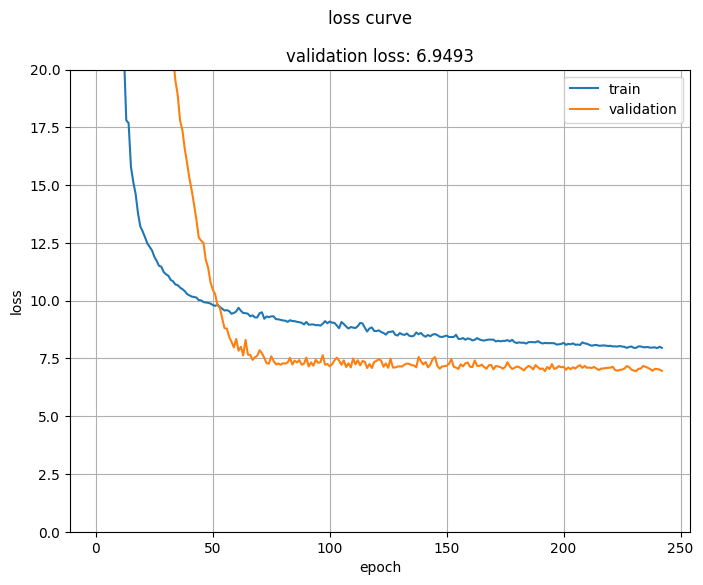

In [8]:
plot_history(history, ymax=20, show=True, title=f'loss curve')

In [9]:
test_dataset_updated = build_updated_dataset(model, test_dataset, BATCH_SIZE, log=False)

1/1 [==============================] - 0s 149ms/step


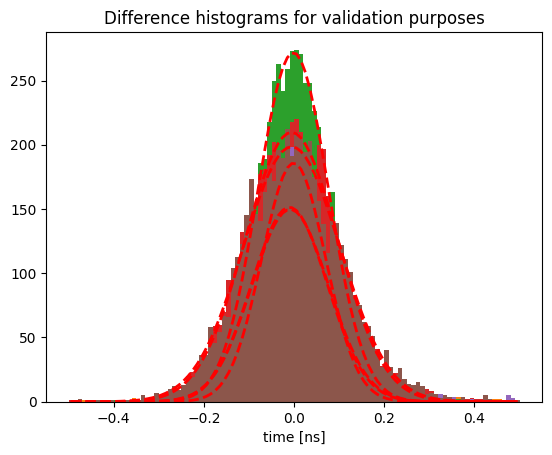

Average precision; stat: 100.80 ps; Gauss  87.79 ps


In [10]:
pairwise_precisions_stat, pairwise_precisions_gauss_nn = compute_pairwise_precisions(
    test_dataset_updated, hists_path=ARTIFACT_DIR / 'pairwise_diff_hists_trained_nn', show=True
)

avg_prec_stat = np.average(list(pairwise_precisions_stat.values()))
avg_prec_gauss = np.average(list(pairwise_precisions_gauss_nn.values()))

print(f"Average precision; stat: {avg_prec_stat:6.2f} ps; Gauss {avg_prec_gauss:6.2f} ps")

In [11]:
deconvolved_precisions_gauss_nn = deconvolve_precisions(pairwise_precisions_gauss_nn)

In [12]:
print('Pairwise - CFD:')
pprint(pairwise_precisions_gauss_cfd)
print('Pairwise - NN:')
pprint(pairwise_precisions_gauss_nn)

Pairwise - CFD:
{((1, 2), (2, 2)): 82.77517877692819,
 ((1, 2), (3, 2)): 95.88694475066676,
 ((1, 11), (2, 11)): 92.44249292059501,
 ((1, 11), (3, 11)): 118.7050160159918,
 ((2, 2), (3, 2)): 98.55256358496375,
 ((2, 11), (3, 11)): 123.02312279329534}
Pairwise - NN:
{((1, 2), (2, 2)): 70.32417517365072,
 ((1, 2), (3, 2)): 84.95647734182734,
 ((1, 11), (2, 11)): 78.34267028935724,
 ((1, 11), (3, 11)): 102.19756395454769,
 ((2, 2), (3, 2)): 83.79149687646652,
 ((2, 11), (3, 11)): 107.12556870276669}


In [13]:
print('Gauss:')
for p_ch in sorted(deconvolved_precisions_gauss_cfd.keys(), key=lambda x: x[1]):
    val_cfd = deconvolved_precisions_gauss_cfd[p_ch]
    val_nn = deconvolved_precisions_gauss_nn[p_ch]
    print(
        f'{str(p_ch):>7} CFD: {val_cfd:>5.1f} ps, NN: {val_nn:>5.1f} ps, improvement: {(1 - val_nn / val_cfd) * 100:0.2f} %')

Gauss:
 (1, 2) CFD:  56.3 ps, NN:  50.7 ps, improvement: 9.89 %
 (2, 2) CFD:  60.7 ps, NN:  48.7 ps, improvement: 19.73 %
 (3, 2) CFD:  77.6 ps, NN:  68.2 ps, improvement: 12.20 %
(1, 11) CFD:  61.2 ps, NN:  50.5 ps, improvement: 17.50 %
(2, 11) CFD:  69.2 ps, NN:  59.9 ps, improvement: 13.54 %
(3, 11) CFD: 101.7 ps, NN:  88.8 ps, improvement: 12.64 %


# Difference histograms: CFD and NN

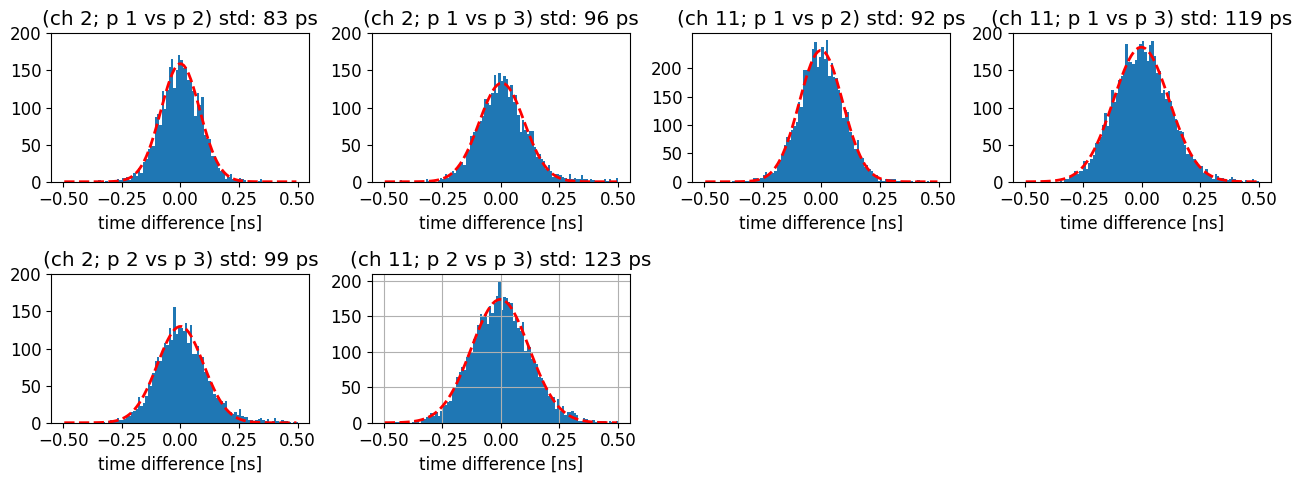

In [14]:
dataset_global_t = copy.deepcopy(test_dataset.t0)
for key in test_dataset.t_pred.keys():
    mask = test_dataset.notnan_mask[key]
    dataset_global_t[key][mask] += test_dataset.t_pred[key][mask]

plt.figure(figsize=(13, 5))
plt.rc('font', size=12)
i_plot = 1
for p_ch1, p_ch2 in combinations(dataset_global_t.keys(), 2):
    if p_ch1[1] == p_ch2[1]:  # Only for corresponding channels
        plt.subplot(2, 4, i_plot)
        i_plot += 1
        ch1_timestamps, ch2_timestamps = dataset_global_t[p_ch1], dataset_global_t[p_ch2]
        differences = [ch2_t - ch1_t for ch1_t, ch2_t in zip(ch1_timestamps, ch2_timestamps) if
                       not np.isnan(ch1_t) and not np.isnan(ch2_t)]

        std_stat = np.std(differences)
        _, std_gauss, _, _ = plot_gauss_hist(np.array(differences), show=False, xlabel='time difference [ns]')
        plt.title(f"(ch {p_ch1[1]}; p {p_ch1[0]} vs p {p_ch2[0]}) std: {std_gauss * 1000:0.0f} ps")
        plt.yticks([0, 50, 100, 150, 200])

plt.tight_layout()
plt.grid()
save_plt(ARTIFACT_DIR / 'cfd_pairwise.pdf')
plt.show()

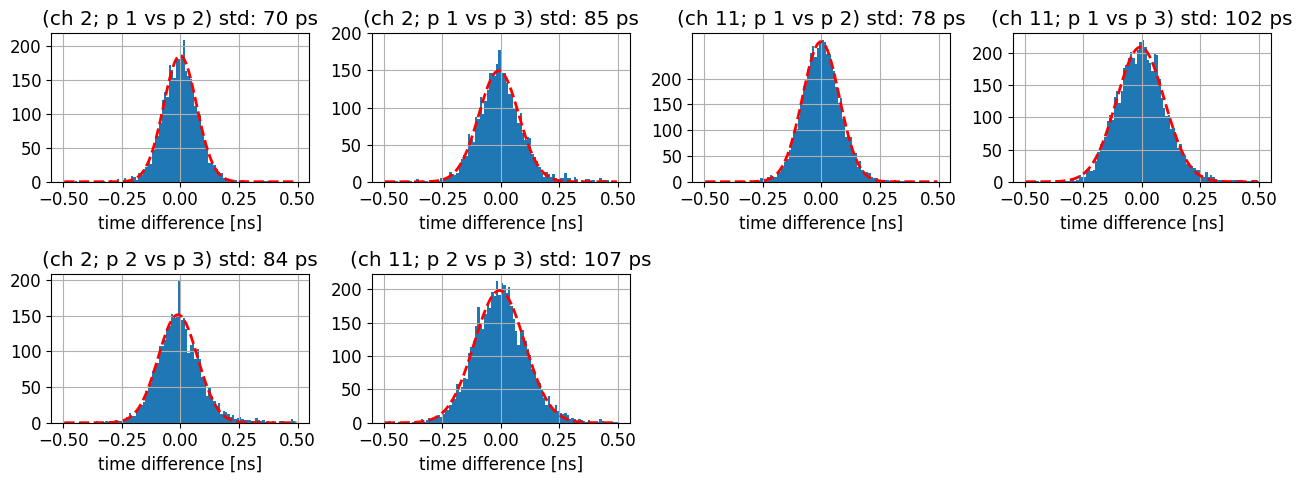

In [15]:
dataset_global_t = copy.deepcopy(test_dataset_updated.t0)
for key in test_dataset.t_pred.keys():
    mask = test_dataset_updated.notnan_mask[key]
    dataset_global_t[key][mask] += test_dataset_updated.t_pred[key][mask]

plt.figure(figsize=(13, 5))
plt.rc('font', size=12)
i_plot = 1
for p_ch1, p_ch2 in combinations(dataset_global_t.keys(), 2):
    if p_ch1[1] == p_ch2[1]:  # Only for corresponding channels
        plt.subplot(2, 4, i_plot)
        i_plot += 1
        ch1_timestamps, ch2_timestamps = dataset_global_t[p_ch1], dataset_global_t[p_ch2]
        differences = [ch2_t - ch1_t for ch1_t, ch2_t in zip(ch1_timestamps, ch2_timestamps) if
                       not np.isnan(ch1_t) and not np.isnan(ch2_t)]

        std_stat = np.std(differences)
        _, std_gauss, _, _ = plot_gauss_hist(np.array(differences), show=False, xlabel='time difference [ns]')
        plt.title(f"(ch {p_ch1[1]}; p {p_ch1[0]} vs p {p_ch2[0]}) std: {std_gauss * 1000:0.0f} ps")
        plt.yticks([0, 50, 100, 150, 200])
        plt.grid()

plt.tight_layout()
save_plt(ARTIFACT_DIR / 'nn_pairwise.pdf')
plt.show()

---
# Pairwise diffs of two-channel averages

In [16]:
def compute_pairwise_precisions_2ch(dataset: ExpandedDataset, save_name: str | None):
    dataset_cfd_2ch = {}
    for p_ch1, p_ch2 in combinations(dataset.keys(), 2):
        if p_ch1[1] == p_ch2[1]:  # Only for corresponding channels
            ch1_timestamps = dataset.t_pred[p_ch1] + dataset.t0[p_ch1]
            ch2_timestamps = dataset.t_pred[p_ch2] + dataset.t0[p_ch2]

            dataset_cfd_2ch[(p_ch1, p_ch2)] = (ch1_timestamps + ch2_timestamps) / 2.

    plt.figure(figsize=(13, 5))
    plt.rc('font', size=12)
    i_plot = 1

    pairwise_precisions = {}
    for (pch11, pch12), (pch21, pch22) in combinations(dataset_cfd_2ch.keys(), 2):
        if pch11[1] == pch12[1] == pch21[1] == pch22[1]:
            plt.subplot(2, 4, i_plot)
            i_plot += 1

            ch1_timestamps, ch2_timestamps = dataset_cfd_2ch[(pch11, pch12)], dataset_cfd_2ch[(pch21, pch22)]
            differences = [ch2_t - ch1_t for ch1_t, ch2_t in zip(ch1_timestamps, ch2_timestamps) if
                           not np.isnan(ch1_t) and not np.isnan(ch2_t)]

            _, std_gauss, _, _ = plot_gauss_hist(np.array(differences), show=False)
            pairwise_precisions[((pch11, pch12), (pch21, pch22))] = std_gauss * 1000

            plt.title(
                f"{pch11[1]}; ({pch11[0]}, {pch12[0]}) vs ({pch21[0]}, {pch22[0]}): std: {std_gauss * 1000:0.0f} ps")
            plt.yticks([0, 150, 300, 450, 600])
            plt.grid()

    plt.tight_layout()

    if save_name is not None:
        save_plt(ARTIFACT_DIR / save_name)
    plt.show()

    return pairwise_precisions

## CFD

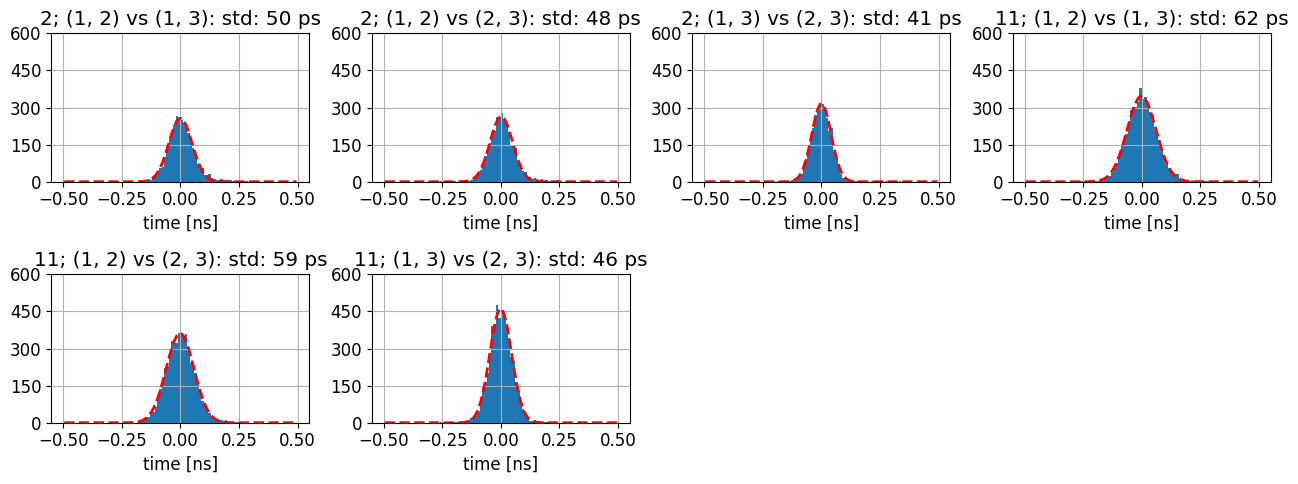

In [17]:
precisions_2ch_cfd = compute_pairwise_precisions_2ch(test_dataset, 'cfd_2ch_pairwise.pdf')

## NN

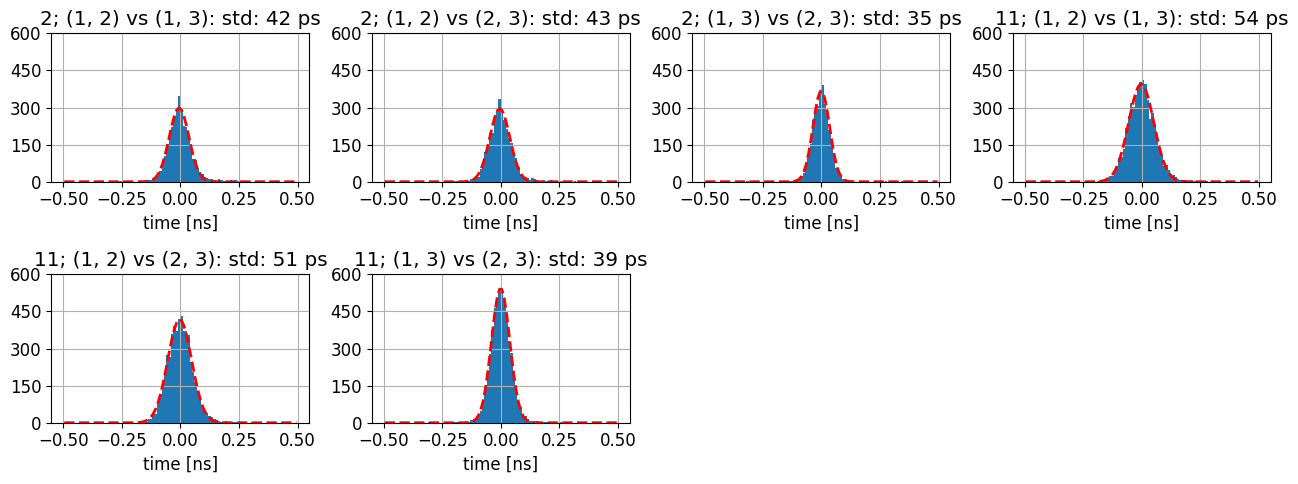

In [18]:
precisions_2ch_nn = compute_pairwise_precisions_2ch(test_dataset_updated, 'nn_2ch_pairwise.pdf')

## Improvement

In [19]:
print('Gauss:')
for key in sorted(precisions_2ch_cfd.keys(), key=lambda x: x[1]):
    val_cfd = precisions_2ch_cfd[key]
    val_nn = precisions_2ch_nn[key]
    print(
        f'{str(key):>40} CFD: {val_cfd:>5.1f} ps, NN: {val_nn:>5.1f} ps, improvement: {(1 - val_nn / val_cfd) * 100:0.2f} %')

Gauss:
    (((1, 2), (2, 2)), ((1, 2), (3, 2))) CFD:  49.5 ps, NN:  41.9 ps, improvement: 15.33 %
(((1, 11), (2, 11)), ((1, 11), (3, 11))) CFD:  61.6 ps, NN:  53.6 ps, improvement: 12.89 %
    (((1, 2), (2, 2)), ((2, 2), (3, 2))) CFD:  48.1 ps, NN:  42.7 ps, improvement: 11.24 %
    (((1, 2), (3, 2)), ((2, 2), (3, 2))) CFD:  41.3 ps, NN:  35.4 ps, improvement: 14.49 %
(((1, 11), (2, 11)), ((2, 11), (3, 11))) CFD:  59.3 ps, NN:  51.0 ps, improvement: 13.98 %
(((1, 11), (3, 11)), ((2, 11), (3, 11))) CFD:  46.3 ps, NN:  39.1 ps, improvement: 15.51 %


# Deconvolution: TODO

In [20]:
def _sorted_pair(a, b):
    return (a, b) if b > a else (b, a)

def deconvolve_precision_2ch(p1: int, p2: int, prec_dict: dict) -> float:
    """
    sigma(1, 2)^2 = sigma(1, 2, 1, 3)^2 + sigma(1, 2, 2, 3)^2 - sigma(1, 3, 2, 3)^2
    """
    pair0 = _sorted_pair(p1, p2)
    p3 = list({1, 2, 3} - {p1, p2})[0]
    pair1 = _sorted_pair(p1, p3)
    pair2 = _sorted_pair(p2, p3)

    pos_pair_1 = prec_dict[_sorted_pair(pair0, pair1)]
    pos_pair_2 = prec_dict[_sorted_pair(pair0, pair2)]
    neg_pair = prec_dict[_sorted_pair(pair1, pair2)]

    return math.sqrt((pos_pair_1 ** 2 + pos_pair_2 ** 2 - neg_pair ** 2) / 2)

def deconvolve_2ch_all(prec_dict: dict):
    channel_mutual_precisions: dict = defaultdict(dict)
    for ((ch11, ch12), (ch21, ch22)), precision in prec_dict.items():
        assert ch11[1] == ch12[1] == ch21[1] == ch22[1]
        channel_mutual_precisions[ch11[1]][((ch11[0], ch12[0]), (ch21[0], ch22[0]))] = precision

    deconvolved_precisions = {}
    for ch, prec_dict in channel_mutual_precisions.items():
        for p1, p2 in combinations(PLANES, 2):
            deconvolved_precisions[((p1, ch), (p2, ch))] = deconvolve_precision_2ch(p1, p2, prec_dict)

    return deconvolved_precisions

In [21]:
deconvolved_pairs_2ch_cfd = deconvolve_2ch_all(precisions_2ch_cfd)
deconvolved_pairs_2ch_nn = deconvolve_2ch_all(precisions_2ch_nn)

print('CFD')
pprint(deconvolved_pairs_2ch_cfd)
print('NN')
pprint(deconvolved_pairs_2ch_nn)

CFD
{((1, 2), (2, 2)): 39.10283975569815,
 ((1, 2), (3, 2)): 30.423998888824713,
 ((1, 11), (2, 11)): 50.79245285316147,
 ((1, 11), (3, 11)): 34.7651177847382,
 ((2, 2), (3, 2)): 27.993303324229604,
 ((2, 11), (3, 11)): 30.593066660238758}
NN
{((1, 2), (2, 2)): 34.144921433608665,
 ((1, 2), (3, 2)): 24.368958362410634,
 ((1, 11), (2, 11)): 44.4163142831055,
 ((1, 11), (3, 11)): 30.036724949579213,
 ((2, 2), (3, 2)): 25.610788589669095,
 ((2, 11), (3, 11)): 25.07303166139449}


In [22]:
from src.dataset import PlaneChannel


def deconvolve_precision(p: int, prec_dict: dict[PlaneChannel, float]) -> float:
    """
    sigma(1)^2 = sigma(1, 2)^2 + sigma(1, 3)^2 - sigma(2, 3)^2
    """
    p1 = (p - PLANE_0 + 1) % N_PLANES + PLANE_0
    p2 = (p - PLANE_0 + 2) % N_PLANES + PLANE_0

    pos_pair_1 = prec_dict[_sorted_pair(p, p1)]
    pos_pair_2 = prec_dict[_sorted_pair(p, p2)]
    neg_pair = prec_dict[_sorted_pair(p1, p2)]

    print(pos_pair_1, pos_pair_2, neg_pair)
    print((pos_pair_1 ** 2 + pos_pair_2 ** 2 - neg_pair ** 2) / 2)
    print(math.sqrt((pos_pair_1 ** 2 + pos_pair_2 ** 2 - neg_pair ** 2) / 2))
    return math.sqrt((pos_pair_1 ** 2 + pos_pair_2 ** 2 - neg_pair ** 2) / 2)


def deconvolve_precisions(prec_dict: dict[tuple[PlaneChannel, PlaneChannel], float]) -> dict[PlaneChannel, float]:
    channel_mutual_precisions: dict[int, dict[tuple[int, int], float]] = defaultdict(dict)
    for ((x_p, x_ch), (y_p, y_ch)), precision in prec_dict.items():
        assert x_ch == y_ch
        channel_mutual_precisions[x_ch][(x_p, y_p)] = precision

    deconvolved_precisions = {}
    for ch, prec_dict in channel_mutual_precisions.items():
        for p in PLANES:
            deconvolved_precisions[(p, ch)] = deconvolve_precision(p, prec_dict)

    return deconvolved_precisions

In [23]:
deconvolved_2ch_cfd = deconvolve_precisions(deconvolved_pairs_2ch_cfd)
deconvolved_2ch_nn = deconvolve_precisions(deconvolved_pairs_2ch_nn)

39.10283975569815 30.423998888824713 27.993303324229604
835.5133771723454
28.905248263461523
27.993303324229604 39.10283975569815 30.423998888824713
693.5186997874622
26.33474320716764
30.423998888824713 27.993303324229604 39.10283975569815
90.10633121486194
9.492435473305148
50.79245285316147 34.7651177847382 30.593066660238758
1426.2754768747695
37.76606250160016
30.593066660238758 50.79245285316147 34.7651177847382
1153.5977899658615
33.96465501025826
34.7651177847382 30.593066660238758 50.79245285316147
-217.66206228804913


ValueError: math domain error

In [ ]:
print('Gauss:')
for p_ch in sorted(deconvolved_precisions_gauss_cfd.keys(), key=lambda x: x[1]):
    val_cfd = deconvolved_2ch_cfd[p_ch]
    val_nn = deconvolved_2ch_nn[p_ch]
    print(
        f'{str(p_ch):>7} CFD: {val_cfd:>5.1f} ps, NN: {val_nn:>5.1f} ps, improvement: {(1 - val_nn / val_cfd) * 100:0.2f} %')